## Libraries

In [8]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from scipy import stats
import math


import time

import matplotlib.pyplot as plt
import seaborn as sns


In [58]:
data = pd.read_csv('real_state.csv').drop(columns='No')
col_list = [
    'transaction_date',
    'house_age',
    'dist_to_MRT',
    'number_stores',
    'lat',
    'longitude',
    'Price'
]

data.columns = col_list


## Data description

In [10]:
display(data.head(1))

display('Data description:', data.describe())

display('Data types:',data.dtypes)

display('Checking NAs:',data.isnull().sum())



transaction_date  house_age  dist_to_MRT  number_stores       lat  \
0          2012.917       32.0     84.87882             10  24.98298   

   longitude  Price  
0  121.54024   37.9

'Data description:'

transaction_date   house_age  dist_to_MRT  number_stores         lat  \
count        414.000000  414.000000   414.000000     414.000000  414.000000   
mean        2013.148971   17.712560  1083.885689       4.094203   24.969030   
std            0.281967   11.392485  1262.109595       2.945562    0.012410   
min         2012.667000    0.000000    23.382840       0.000000   24.932070   
25%         2012.917000    9.025000   289.324800       1.000000   24.963000   
50%         2013.167000   16.100000   492.231300       4.000000   24.971100   
75%         2013.417000   28.150000  1454.279000       6.000000   24.977455   
max         2013.583000   43.800000  6488.021000      10.000000   25.014590   

        longitude       Price  
count  414.000000  414.000000  
mean   121.533361   37.980193  
std      0.015347   13.606488  
min    121.473530    7.600000  
25%    121.528085   27.700000  
50%    121.538630   38.450000  
75%    121.543305   46.600000  
max    121.566270  117.500000

'Data types:'

transaction_date    float64
house_age           float64
dist_to_MRT         float64
number_stores         int64
lat                 float64
longitude           float64
Price               float64
dtype: object

'Checking NAs:'

transaction_date    0
house_age           0
dist_to_MRT         0
number_stores       0
lat                 0
longitude           0
Price               0
dtype: int64

## Plots

### Scatter plot: Y vs X

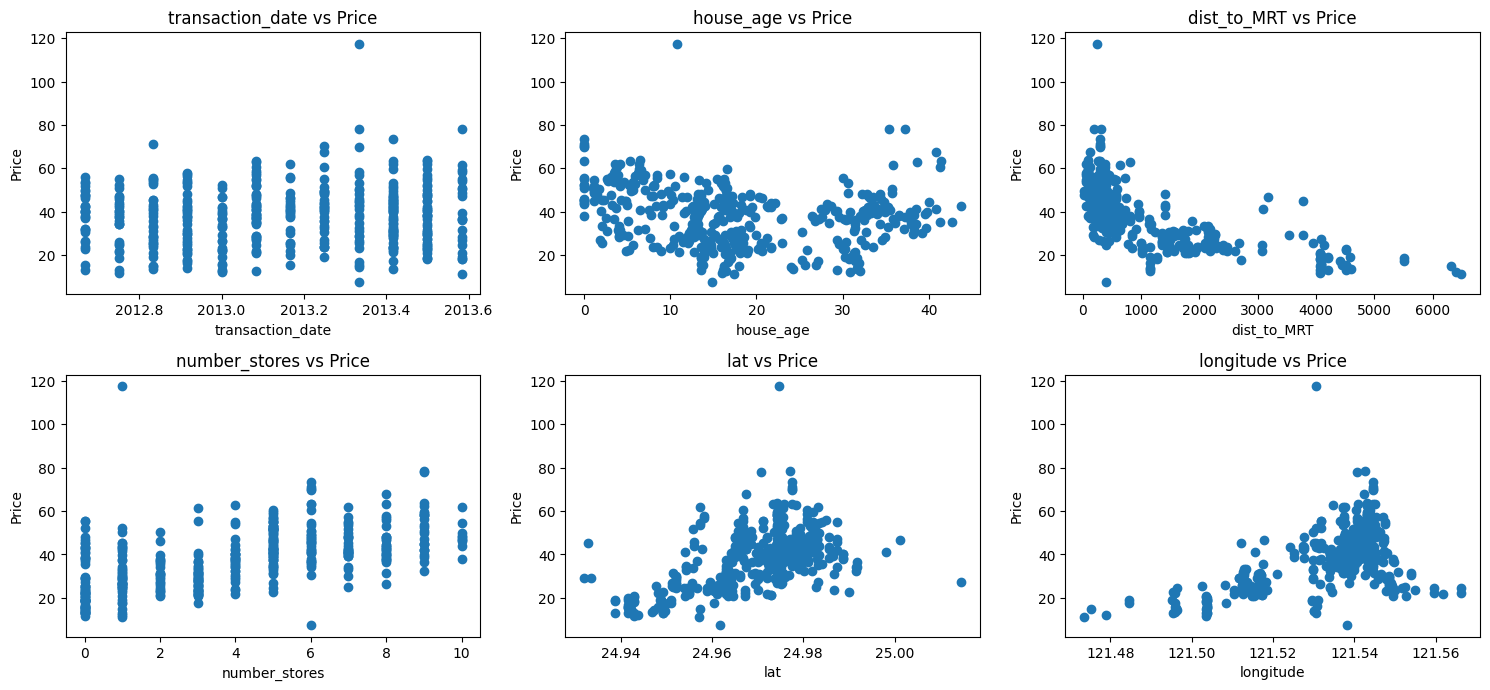

In [11]:
x_vars =data.drop(columns=["Price"]).columns

fig, axs = plt.subplots(3, 3, figsize=(15, 10))  # Adjust the figure size as needed
axs = axs.flatten()  # Flatten the array of axes

for i, col in enumerate(x_vars):
    axs[i].scatter(data[col], data['Price'])
    axs[i].set_title(f'{col} vs Price')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Price')

# Hide the last subplot (if there are any empty ones)
for ax in axs[len(x_vars):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

### Histogram

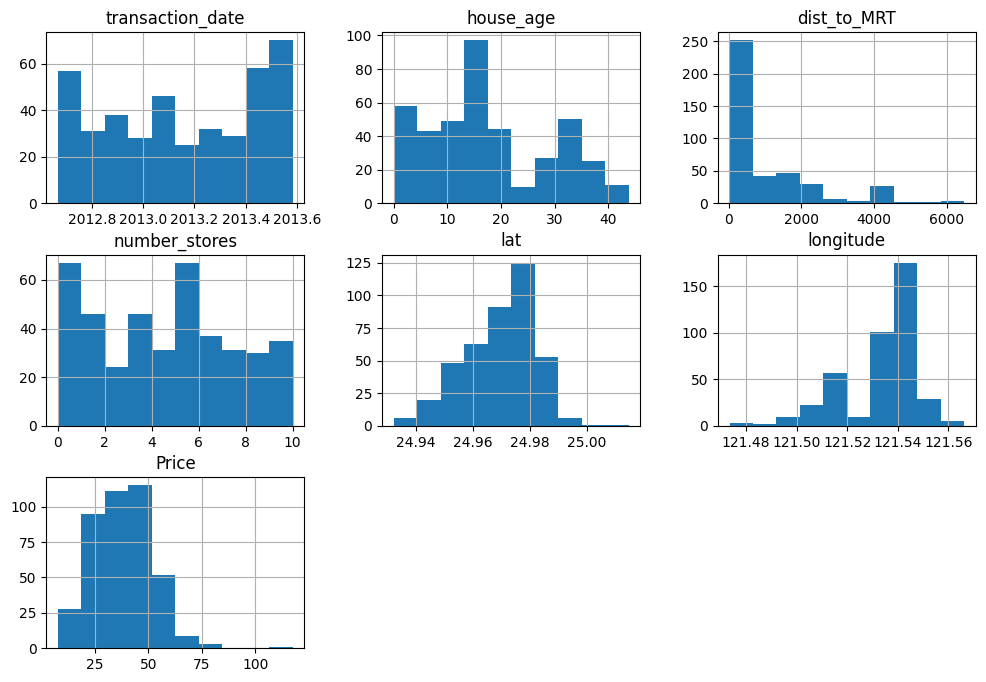

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

data.hist(figsize=(12, 8))
plt.show()



### Box plot


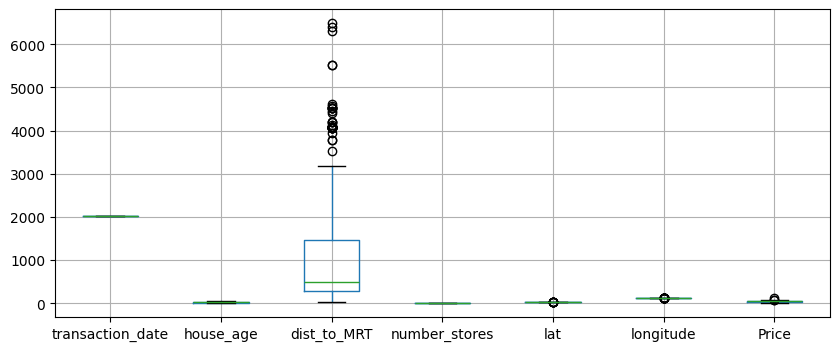

In [63]:
data.boxplot(figsize=(10, 4))
plt.show()

### Heatmap for correlation

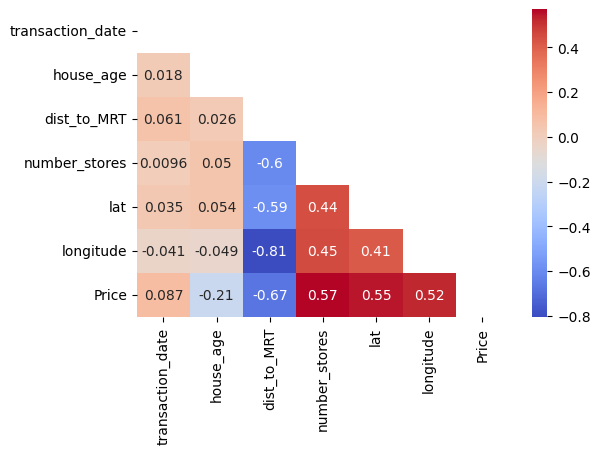

In [14]:
corr_matrix = data.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', mask=mask)
plt.show()

**Comments**:   
- There is a high correlation between `dist_to_MRT` and `lat` and `longitude`, so I drop the `lat` and `longitude` columns      
- `dist_to_MRT` is right skewed, so I use log transformation to deal with it.    
- `house_age` has quadratic relationship with response.   
- There is no influential points.   


In [64]:
data2 = data.copy()
data2['log_dist_to_MRT'] =  np.log(data2.dist_to_MRT)
data2['squared_house_age'] =  (data2.house_age)**2

# data2.hist(figsize=(12, 8))
# plt.show()


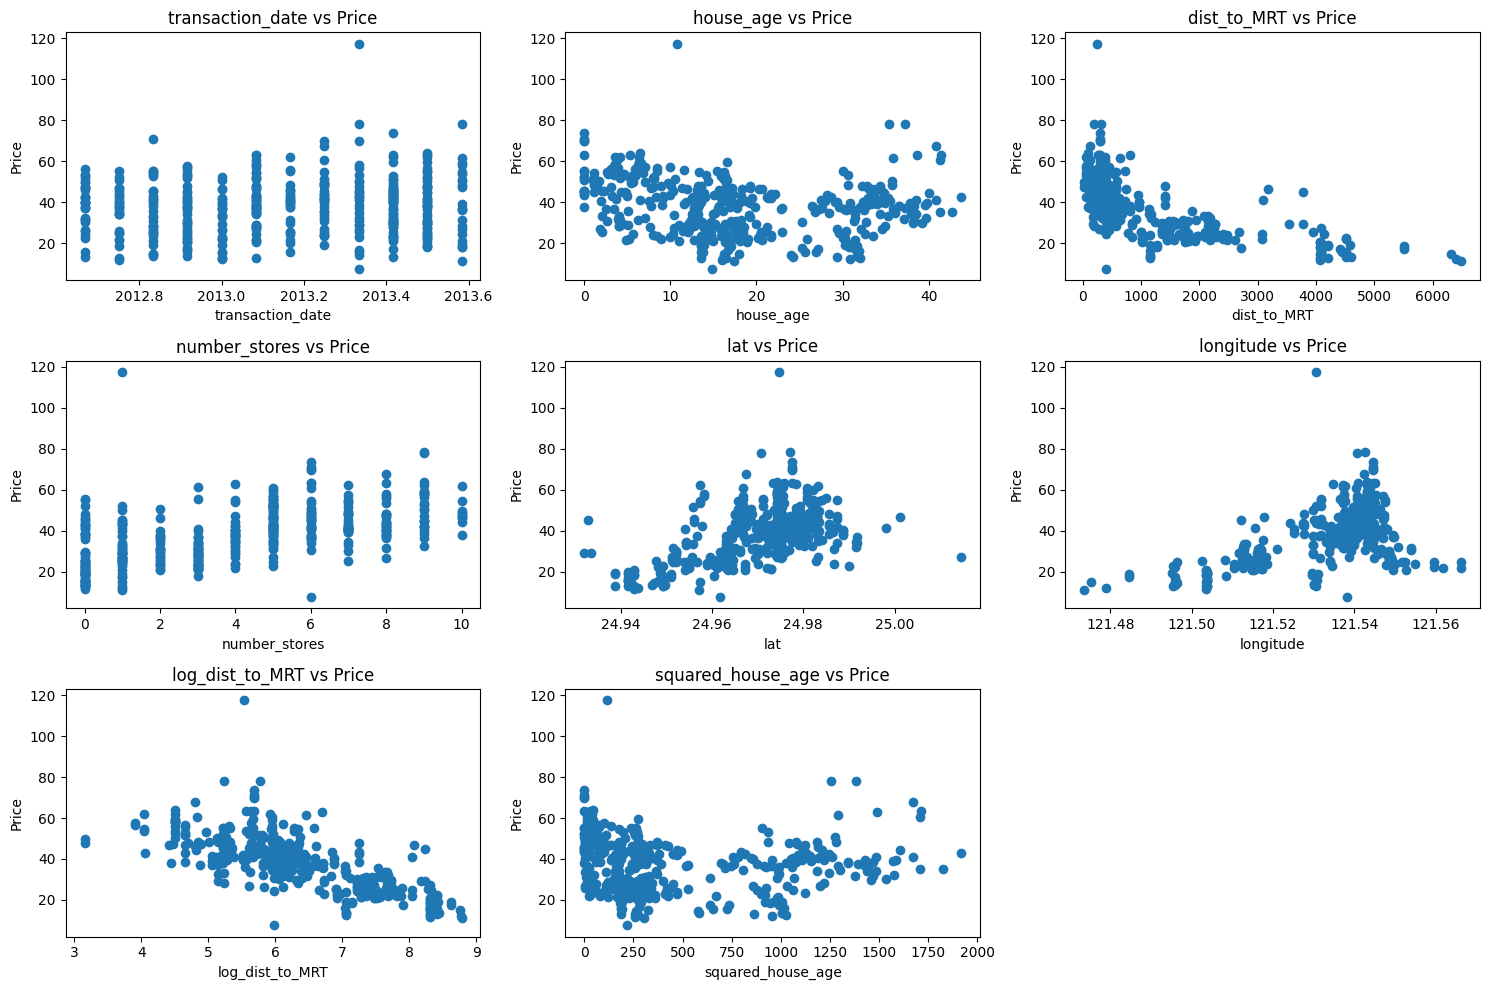

In [65]:
x_vars =data2.drop(columns=["Price"]).columns

fig, axs = plt.subplots(3, 3, figsize=(15, 10))  # Adjust the figure size as needed
axs = axs.flatten()  # Flatten the array of axes

for i, col in enumerate(x_vars):
    axs[i].scatter(data2[col], data2['Price'])
    axs[i].set_title(f'{col} vs Price')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Price')

for ax in axs[len(x_vars):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

## Checking Assumptios

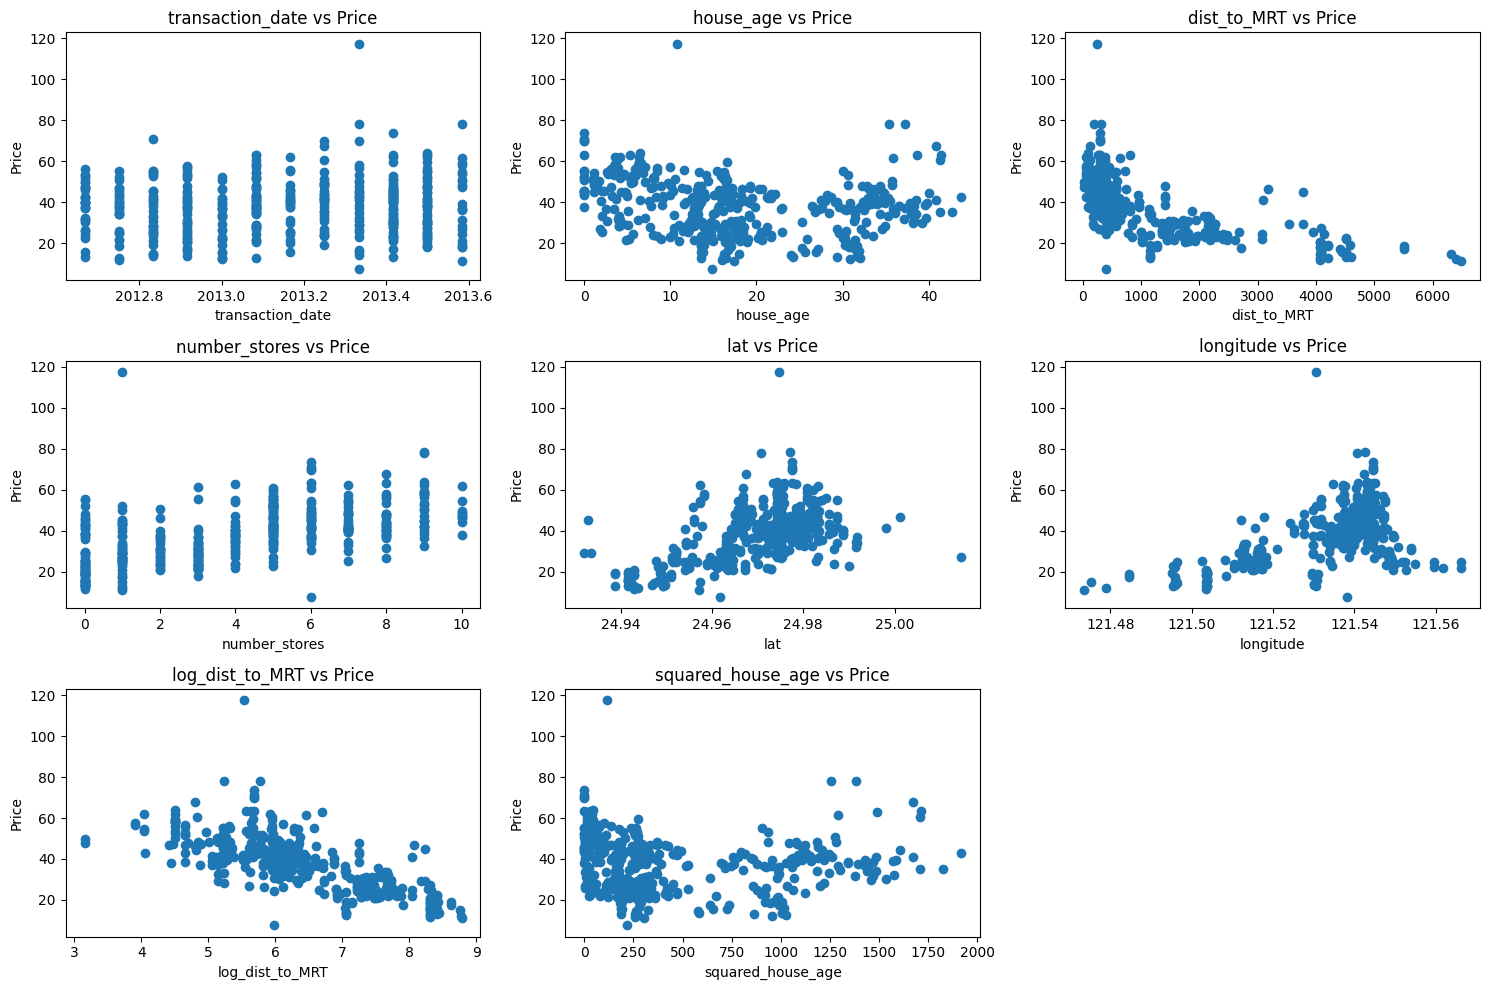

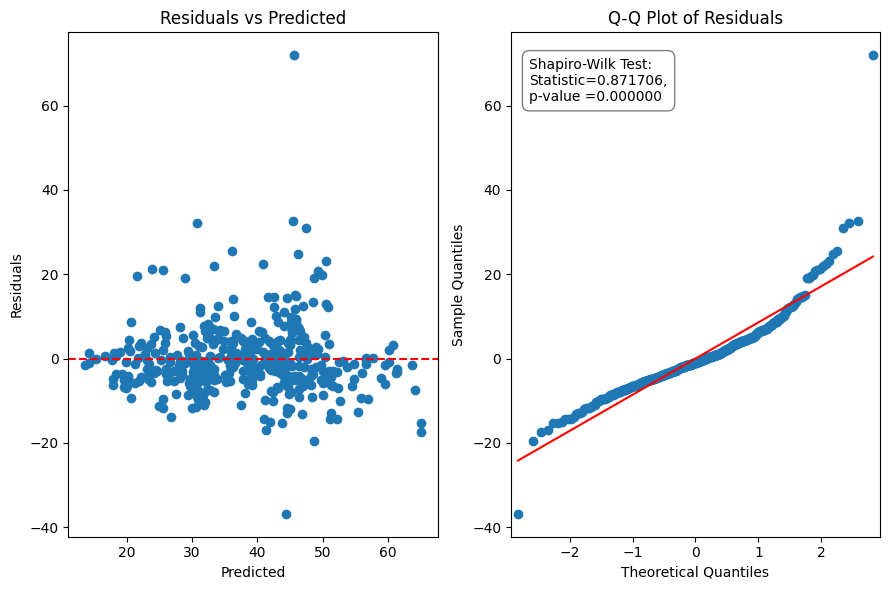

In [57]:
# Linearity
x_vars =data2.drop(columns=["Price"]).columns

fig, axs = plt.subplots(3, 3, figsize=(15, 10))  # Adjust the figure size as needed
axs = axs.flatten()  # Flatten the array of axes

for i, col in enumerate(x_vars):
    axs[i].scatter(data2[col], data2['Price'])
    axs[i].set_title(f'{col} vs Price')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Price')


for ax in axs[len(x_vars):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

# Homoscedasticity & Normality of Residuals & Shapiro test

X_with_constant = sm.add_constant(x)
model = sm.OLS(y, X_with_constant).fit()
residuals = model.resid


fig, axs = plt.subplots(1, 2, figsize=(9, 6))

axs[0].scatter(model.predict(), residuals)
axs[0].set_title('Residuals vs Predicted')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('Residuals')
axs[0].axhline(y=0, color='r', linestyle='--')

shapiro_test = stats.shapiro(residuals)
shapiro_text = f'Shapiro-Wilk Test:\nStatistic={shapiro_test.statistic:.6f},\np-value ={shapiro_test.pvalue:.6f}'

sm.qqplot(residuals, line='s', ax=axs[1])
axs[1].set_title('Q-Q Plot of Residuals')
axs[1].text(0.05, 0.95, shapiro_text, transform=axs[1].transAxes, 
            fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()




## MLR

Create an empty DataFrame to save the result of all models

In [33]:
index = ['MyModel', 'MyModel_cv5','Sklearn', 'Sklearn_cv5']
columns = ['R_Squared', 'RMSE_Train', 'RMSE_Test', 'Run_Time']
df_result = pd.DataFrame(columns=columns, index=index)
# df_result

### From Scratch

In [35]:
from LinearRegression import LinearRegression
x = data2.drop(columns=["Price", 'lat', 'longitude', 'dist_to_MRT','squared_house_age'])
y = data2.Price
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

start_time = time.time()
mymodel = LinearRegression()
mymodel.fit(x_train, y_train)
end_time = time.time()

print("My model R-squared :", mymodel.r_squared(x_train, y_train))

print("My model RMSE Train:", mymodel.rmse(x_train, y_train))
print("My model RMSE Test :", mymodel.rmse(x_test, y_test))
print("My model RMSE Total:", mymodel.rmse(x, y))
df_result.loc["MyModel",:] = [mymodel.r_squared(x_train, y_train), mymodel.rmse(x_train, y_train), mymodel.rmse(x_test, y_test), (end_time - start_time)]
# df_result


My model R-squared : 0.582480600140874
My model RMSE Train: 8.917126277342655
My model RMSE Test : 7.815001728161726
My model RMSE Total: 8.599258094011383


#### CV = 5

In [36]:
import numpy as np
from sklearn.model_selection import KFold

# Assuming your LinearRegression class is defined as in your previous code

def cross_validate(model, X, y, cv=5):
    kf = KFold(n_splits=cv)
    rmse_scores_train = []
    rmse_scores_test = []
    r2_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        rmse_scores_train.append(model.rmse(X_train, y_train))
        rmse_scores_test.append(model.rmse(X_test, y_test))
        r2_scores.append(model.r_squared(X_train, y_train))

    return np.mean(r2_scores), np.mean(rmse_scores_train), np.mean(rmse_scores_test)

start_time = time.time()

r2, rmse_train, rmse_test = cross_validate(mymodel, x, y, cv=5)
end_time = time.time()


# Print the results
print(f"My model cv5 R Squared : {r2}")
print(f"My model cv5 RMSE train: {rmse_train}")
print(f"My model cv5 RMSE test : {rmse_test}")
df_result.loc["MyModel_cv5",:] = [r2, rmse_train, rmse_test, (end_time - start_time)]


My model cv5 R Squared : 0.6026869322838763
My model cv5 RMSE train: 8.563195814713897
My model cv5 RMSE test : 8.49273749832991


### SKLearn

In [40]:

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV

start_time = time.time()

sklearn_model = LinearRegression()
sklearn_model.fit(x_train, y_train)
end_time = time.time()

y_pred = sklearn_model.predict(x_test)

# rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
print('sklearn R squared :',sklearn_model.score(x_train,y_train))
print("sklearn RMSE Train:", np.sqrt(np.mean((y_train - sklearn_model.predict(x_train)) ** 2)))
print("sklearn RMSE Test :", np.sqrt(np.mean((y_test - sklearn_model.predict(x_test)) ** 2)))
print("sklearn RMSE Total:", np.sqrt(np.mean((y - sklearn_model.predict(x)) ** 2)))

df_result.loc["Sklearn",:] = [sklearn_model.score(x_train,y_train),np.sqrt(np.mean((y_train - sklearn_model.predict(x_train)) ** 2)), np.sqrt(np.mean((y_test - sklearn_model.predict(x_test)) ** 2)), (end_time - start_time)]


sklearn R squared : 0.5824806001408702
sklearn RMSE Train: 8.917126277342698
sklearn RMSE Test : 7.815001687275313
sklearn RMSE Total: 8.59925808279234


#### CV = 5

In [41]:
sklearn_model_cv5 = LinearRegression()

# Perform 5-fold cross-validation
start_time = time.time()

cv_scores = cross_val_score(sklearn_model_cv5, x_train, y_train, cv=5)
end_time = time.time()

# Output the results
print("Cross-validated scores:", cv_scores)
print("Mean of CV scores:", cv_scores.mean())

y_pred_cv = cross_val_predict(sklearn_model_cv5, x_train, y_train, cv=5)

# Calculate RMSE
rmse_cv = np.sqrt(mean_squared_error(y_train, y_pred_cv))

print('Cross-validated R squared:',cv_scores)

print("Cross-validated RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_cv)))
print("Cross-validated RMSE Train:", np.sqrt(np.mean((y_train - cross_val_predict(sklearn_model_cv5, x_train, y_train, cv=5)) ** 2)))
print("Cross-validated RMSE Test:", np.sqrt(np.mean((y_test - cross_val_predict(sklearn_model_cv5, x_test, y_test, cv=5))** 2)))
print("Cross-validated RMSE Total:", np.sqrt(np.mean((y - cross_val_predict(sklearn_model_cv5, x, y, cv=5))** 2)))

df_result.loc["Sklearn_cv5",:] = [np.mean(cv_scores),np.sqrt(np.mean((y_train - cross_val_predict(sklearn_model_cv5, x_train, y_train, cv=5)) ** 2)), np.sqrt(np.mean((y_test - cross_val_predict(sklearn_model_cv5, x_test, y_test, cv=5))** 2)), (end_time - start_time)]



Cross-validated scores: [0.68950307 0.6423281  0.47455935 0.53068521 0.55120022]
Mean of CV scores: 0.5776551886805621
Cross-validated R squared: [0.68950307 0.6423281  0.47455935 0.53068521 0.55120022]
Cross-validated RMSE: 9.053786196636613
Cross-validated RMSE Train: 9.053786196636613
Cross-validated RMSE Test: 7.999592303606404
Cross-validated RMSE Total: 8.641652556353952


## Comparing models

In [42]:
df_result

R_Squared RMSE_Train RMSE_Test  Run_Time
MyModel      0.582481   8.917126  7.815002  0.002024
MyModel_cv5  0.602687   8.563196  8.492737  0.021349
Sklearn      0.582481   8.917126  7.815002  0.004425
Sklearn_cv5  0.577655   9.053786  7.999592  0.028833

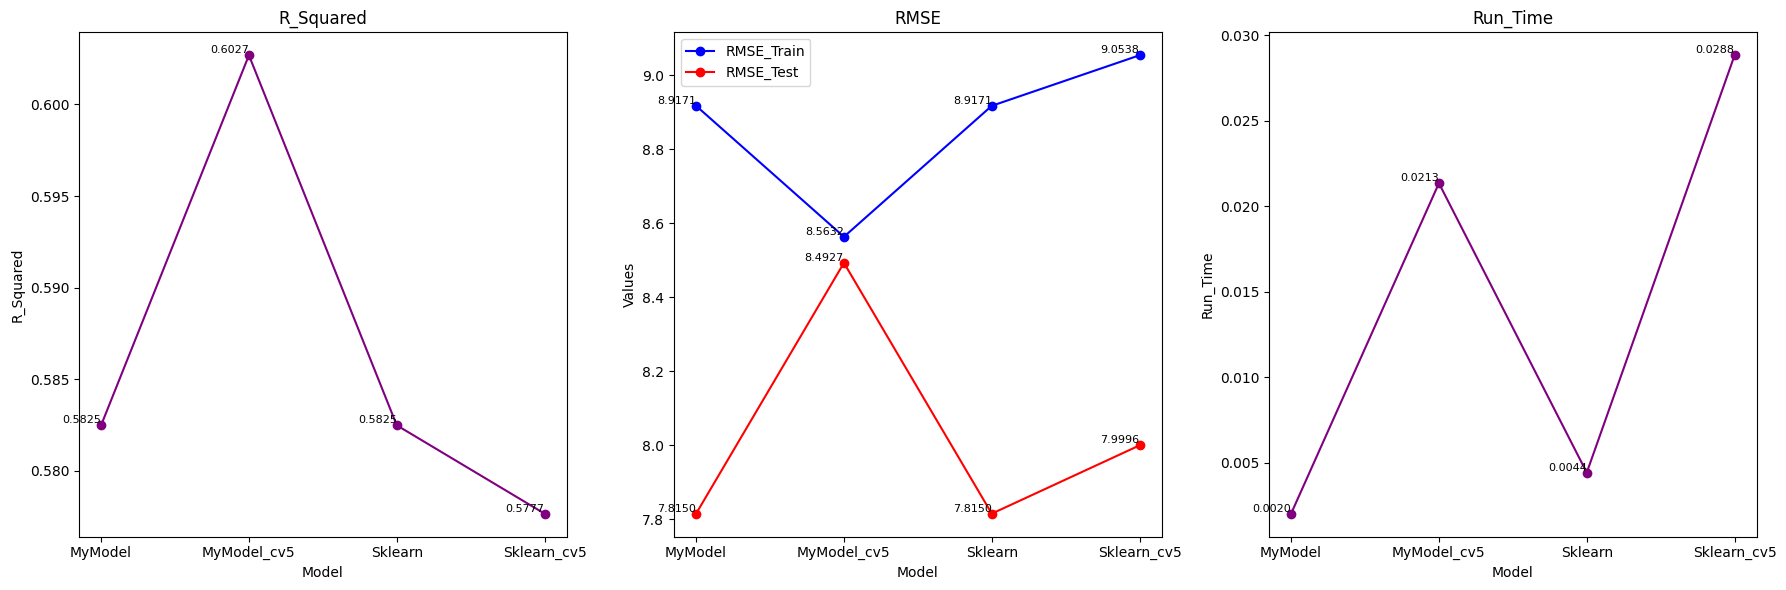

In [43]:
import matplotlib.pyplot as plt
import pandas as pd


fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# column 1
axs[0].plot(df_result[df_result.columns[0]], color='purple', marker='o', linestyle='-')
for idx, value in enumerate(df_result[df_result.columns[0]]):
    axs[0].text(idx, value, f'{value:.4f}', ha='right', va='bottom', fontsize=8)
axs[0].set_title(f'{df_result.columns[0]}')
axs[0].set_xlabel('Model')
axs[0].set_ylabel(df_result.columns[0])

# columns 2 and 3 combined
axs[1].plot(df_result[df_result.columns[1]], color='blue', marker='o', linestyle='-')
axs[1].plot(df_result[df_result.columns[2]], color='red', marker='o', linestyle='-')
for idx, value in enumerate(df_result[df_result.columns[1]]):
    axs[1].text(idx, value, f'{value:.4f}', ha='right', va='bottom', fontsize=8)
for idx, value in enumerate(df_result[df_result.columns[2]]):
    axs[1].text(idx, value, f'{value:.4f}', ha='right', va='bottom', fontsize=8)
axs[1].set_title('RMSE')
axs[1].set_xlabel('Model')
axs[1].set_ylabel('Values')
axs[1].legend([df_result.columns[1], df_result.columns[2]])

# column 4
axs[2].plot(df_result[df_result.columns[3]], color='purple', marker='o', linestyle='-')
for idx, value in enumerate(df_result[df_result.columns[3]]):
    axs[2].text(idx, value, f'{value:.4f}', ha='right', va='bottom', fontsize=8)
axs[2].set_title(f'{df_result.columns[3]}')
axs[2].set_xlabel('Model')
axs[2].set_ylabel(df_result.columns[3])

plt.tight_layout()
plt.show()
